<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

<a id="4"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">4- Models</p>

In [246]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models & Evaluation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn import metrics

## Splitting dataset in train and test

In [247]:
def adjusted_r2_score(X, r2_score):
    return 1 - ( 1- r2_score ) * ( len(X) - 1 ) / ( len(X) - X.shape[1] - 1 )

In [248]:
hourly_data = pd.read_csv('../data/interim/hourly_data.csv')

In [249]:
hourly_data.shape

(7447, 15)

In [250]:
hourly_data.columns

Index(['rental_date', 'rental_day', 'rental_year', 'rental_hour', 'holiday',
       'dayofweek', 'working_day', 'season', 'peak', 'timesofday', 'rain',
       'temp', 'rhum', 'wdsp', 'count'],
      dtype='object')

In [251]:
df = hourly_data.copy()
#df = hourlyDataWithoutOutliers.copy()
#df = transform_data.copy()
df = df.astype({'holiday': 'category', 'dayofweek': 'category', 'working_day': 'category', 'peak': 'category', 'timesofday': 'category'})
# predictors = ['rain','temp','wdsp','rhum','holiday','dayofweek','working_day','peak','timesofday']
predictors = ['rhum']
# predictors = ['rain']
# predictors = ['temp']
# predictors = ['wdsp']
# predictors = ['rhum','rain'] # 3.1586, 0.19811
# predictors = ['rhum','temp']
# predictors = ['rhum','wdsp']
# predictors = ['rhum','temp']

X = df[[c for c in df.columns if c in predictors]]
y = df.pop('count')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((5212, 2), (2235, 2))

## Split columns in categorical and numerical

In [252]:
num_vars = [n for n in df.select_dtypes(include=['number']).columns if n in predictors] # list comprehension to select only predictors features
cat_vars = [c for c in df.select_dtypes(include=['category']).columns if c in predictors]

In [253]:
num_vars, cat_vars

(['rain', 'rhum'], [])

## Preprocessing Pipelines

In [254]:
# Define categorical pipeline
cat_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    # ('scaler', MinMaxScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_vars),
    ('num', num_pipe, num_vars)
])

In [255]:
pipe_linear_regression = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipe_linear_regression.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe_linear_regression.predict(X_train)

# Predict test data
y_test_pred = pipe_linear_regression.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.1586080598382247
R^2: 0.1988294677251371
Adjusted R^2: 0.19811157298295534


In [256]:
kldsfjj

NameError: name 'kldsfjj' is not defined

## Feature Importance

In [ ]:
# LightGBM model
params_lightgbm = {'n_estimators': 500, 
                   'boosting_type': 'dart', 
                   'max_depth': 5, 
                   'learning_rate': 0.01, 
                   'subsample': 0.7, 
                   'importance_type': 'gain'
                   }

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dayofweek']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rhum', 'wdsp'])])),
                ('model',
                 LGBMRegressor(boosting_type='dart', importance_type='gain',
                               learning_rate=0.01, max_depth=5,
                               n_estimators=500, subsample=0.7))])

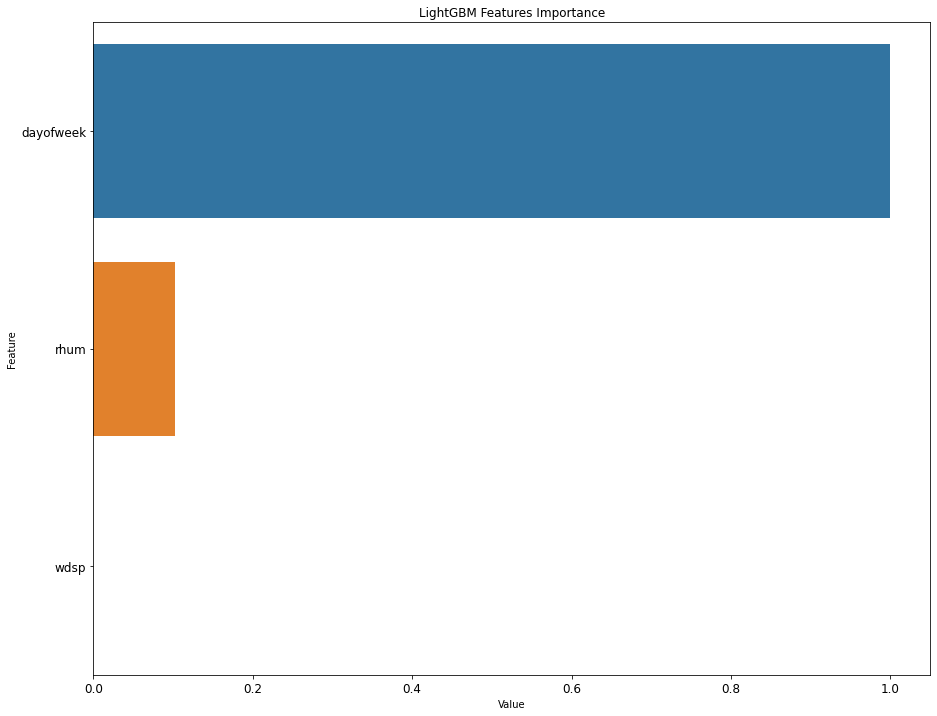

In [ ]:
#Plotting features importance
feature_imp = pd.DataFrame(sorted(zip(pipe_gbm['model'].feature_importances_,X_train.columns)), columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1))

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

## Linear Regression

In [ ]:
pipe_linear_regression = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipe_linear_regression.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe_linear_regression.predict(X_train)

# Predict test data
y_test_pred = pipe_linear_regression.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.139591660855648
R^2: 0.20844732211604622
Adjusted R^2: 0.20738293034838506


## Ridge Regression

[Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients with l2 regularization.

In [ ]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])
pipe_ridge.fit(X_train, y_train)

y_train_pred = pipe_ridge.predict(X_train)
y_test_pred = pipe_ridge.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.140349789036471
R^2: 0.20806499797299183
Adjusted R^2: 0.20700009209845982


## Lasso Regression

The [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) is a linear model that estimates sparse coefficients with l1 regularization.

In [ ]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('model', linear_model.Lasso(alpha=0.1))
])
pipe_lasso.fit(X_train, y_train)
y_train_pred = pipe_lasso.predict(X_train)
y_test_pred = pipe_lasso.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.159947081605668
R^2: 0.1981500468198084
Adjusted R^2: 0.19707180842467587


## Elastic-Net

[Elastic-Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) is a linear regression model trained with both l1 and l2 -norm regularization of the coefficients.

In [ ]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_elastic = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])
pipe_elastic.fit(X_train, y_train)
y_train_pred = pipe_elastic.predict(X_train)
y_test_pred = pipe_elastic.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.3118248840018585
R^2: 0.11921842987009723
Adjusted R^2: 0.11803405303890513


## Random Forest Regressor

In [ ]:
# random forest model
params_rf = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**params_rf))
])
pipe_rf.fit(X_train, y_train)
y_train_pred = pipe_rf.predict(X_train)
y_test_pred = pipe_rf.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.3432885001987374
R^2: 0.10240340230753198
Adjusted R^2: 0.10119641450247718


## GradientBoost

In [ ]:
# GBM model
params_gbm = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.01, 'subsample': 0.7, 'loss': 'ls'}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(**params_gbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.1717881553585325
R^2: 0.19212934219427125
Adjusted R^2: 0.19104300782698425


## LightGBM

In [ ]:
# LightGBM model
params_lightgbm = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'learning_rate': 0.01, 'subsample': 0.7}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.179496669578697
R^2: 0.18819777451763708
Adjusted R^2: 0.1871061534165851


## Catboost

In [ ]:
# Catboost model

# Fit a pipeline with transformers and an estimator to the training data
pipe_catboost = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(verbose=1, n_estimators=100))
])
pipe_catboost.fit(X_train, y_train)
y_train_pred = pipe_catboost.predict(X_train)
y_test_pred = pipe_catboost.predict(X_test)

print('\n')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Learning rate set to 0.30132
0:	learn: 3.3061240	total: 1.94ms	remaining: 192ms
1:	learn: 3.2358414	total: 4.12ms	remaining: 202ms
2:	learn: 3.1873851	total: 5.87ms	remaining: 190ms
3:	learn: 3.1515416	total: 7.28ms	remaining: 175ms
4:	learn: 3.1367226	total: 10ms	remaining: 191ms
5:	learn: 3.1233325	total: 11.8ms	remaining: 185ms
6:	learn: 3.1146854	total: 13.2ms	remaining: 175ms
7:	learn: 3.1091340	total: 15.6ms	remaining: 180ms
8:	learn: 3.1051975	total: 17.1ms	remaining: 173ms
9:	learn: 3.1023883	total: 19ms	remaining: 171ms
10:	learn: 3.0997931	total: 20.4ms	remaining: 165ms
11:	learn: 3.0956363	total: 22ms	remaining: 162ms
12:	learn: 3.0904638	total: 23.6ms	remaining: 158ms
13:	learn: 3.0867410	total: 25.4ms	remaining: 156ms
14:	learn: 3.0856052	total: 27.4ms	remaining: 155ms
15:	learn: 3.0845273	total: 29ms	remaining: 152ms
16:	learn: 3.0830947	total: 30.7ms	remaining: 150ms
17:	learn: 3.0819052	total: 33ms	remaining: 150ms
18:	learn: 3.0759433	total: 34.3ms	remaining: 146ms
19:

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini